Gene Ontology aided Compound Protein Binding
Affinity Prediction Using Neural Network

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Input # type: ignore
from tensorflow.keras.layers import BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve, auc

Loading data

In [2]:
df_davis = pd.read_csv("davis-filter.txt", header=None, sep=" ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])
df_kiba = pd.read_csv("kiba.txt", header=None,sep = " ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])

In [3]:

#check for any missing values in train data
print(df_davis.isnull().any().sum())
#check for any missing values in train data
print(df_kiba.isnull().any().sum())

0
0


Merging the datasets

In [4]:
df = df_davis
df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532
1,11314340,AKT1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186
2,11314340,AKT2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602
3,11314340,AKT3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727
4,11314340,AURKC,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721
...,...,...,...,...,...
9120,151194,PDGFRB,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060
9121,151194,RET(M918T),C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186
9122,151194,VEGFR2,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608
9123,151194,YSK4,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246


Using One-Hot encoding for SMILES and AMINO ACIDS sequence

In [5]:
#for amino acid sequence
# Step 1: Extract unique characters from the specified column ('amino_acid_seq')
unique_chars = sorted(set(''.join(df['amino_acid_seq'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['amino_acid_seq_encoded'] = df['amino_acid_seq'].apply(encode_sequence)

#for SMILES sequence
# Step 1: Extract unique characters from the specified column ('SMILES_seq_drug')
unique_chars = sorted(set(''.join(df['SMILES_seq_drug'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['SMILES_seq_drug_encoded'] = df['SMILES_seq_drug'].apply(encode_sequence)


Padding the amino acid and smiles sequences with 0's to ensure uniformity

In [6]:
# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['amino_acid_seq_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['aa_seq_padded'] = list(padded_seqs)

# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['SMILES_seq_drug_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['smiles_seq_padded'] = list(padded_seqs)

#join the padded sequences
df['drug_protein_encoded'] = df.apply(lambda row: np.concatenate([row['aa_seq_padded'], row['smiles_seq_padded']]), axis = 1)

df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score,amino_acid_seq_encoded,SMILES_seq_drug_encoded,aa_seq_padded,smiles_seq_padded,drug_protein_encoded
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,"[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1..."
1,11314340,AKT1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186,"[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 1, 8, 18, 9, 4, 6, 19, 10, 7, ..."
2,11314340,AKT2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602,"[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 12, 4, 18, 16, 18, 8, 9, 4, 6, 19, 10, 7,..."
3,11314340,AKT3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727,"[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 3, 18, 17, 8, 18, 9, 4, 6, 19, 18, 14..."
4,11314340,AURKC,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721,"[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ...","[16, 16, 5, 14, 16, 6, 16, 14, 16, 2, 16, 14, ...","[11, 16, 16, 13, 15, 1, 18, 18, 14, 10, 6, 9, ..."
...,...,...,...,...,...,...,...,...,...,...
9120,151194,PDGFRB,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060,"[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[1, 1, 16, 4, 13, 3, 17, 1, 6, 16, 18, 15, 6, ..."
9121,151194,RET(M918T),C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186,"[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 1, 9, 1, 17, 16, 6, 1, 1, 6, 10, 15, 10, ..."
9122,151194,VEGFR2,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608,"[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 14, 16, 9, 18, 10, 10, 1, 18, 1, 10, 19, ..."
9123,151194,YSK4,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246,"[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16...","[16, 5, 14, 16, 16, 14, 16, 6, 16, 2, 14, 16, ...","[11, 16, 16, 11, 13, 9, 13, 4, 15, 7, 1, 4, 16..."


Train-test splitting – Case 2
New proteins in test:
90% proteins are present in the train, with all their drug interactions and remaining proteins with all their interactions are present in test



In [7]:

# Separate proteins into training and test sets (90% for training, 10% for testing)
train_proteins, test_proteins = train_test_split(df['protein_id'].unique(), test_size=0.1, random_state=42)

# Now we can create a train and test dataset by filtering the DataFrame based on the protein ids
train_df = df[df['protein_id'].isin(train_proteins)]
test_df = df[df['protein_id'].isin(test_proteins)]

# Shuffle the final train and test data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


Checking whether the split happened properly

In [8]:
print(train_df.shape)
print(test_df.shape)

train_list = train_df['protein_id'].unique()
test_list = test_df['protein_id'].unique()

for i in test_list:
    if(i in train_list): print("Error")
else: print("Split performed correctly")

(8271, 10)
(854, 10)
Split performed correctly


Building the Neural Network

In [82]:
model = Sequential()

model.add(Input(shape=(2641,)))

model.add(Dense(1320, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(330, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(75, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))

Compiling the model

In [83]:
#Optimizer
optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999 )

#Compiling the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 1320)           │     3,487,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 1320)           │         5,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 330)            │       435,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 330)            │         1,320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 330)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 75)             │        24,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,956,392 (15.09 MB)

 Trainable params: 3,952,910 (15.08 MB)

 Non-trainable params: 3,482 (13.60 KB)

Training the model

In [84]:
x_train = train_df['drug_protein_encoded']
x_train = pad_sequences(x_train, padding='post', dtype='int8')
y_train = train_df['affinity_score']

x_test = test_df['drug_protein_encoded']
x_test = pad_sequences(x_test, padding='post', dtype='int8')
y_test = test_df['affinity_score']

batch_size = 400
epochs = 25

customLR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1,  
    min_delta=0.0001, 
    min_lr=1e-6,
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_test, y_test), verbose=1, callbacks = [customLR])

Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 39.7305 - mae: 6.1557 - val_loss: 806.5334 - val_mae: 22.1927 - learning_rate: 0.0100
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 18.5766 - mae: 4.1128 - val_loss: 144.7065 - val_mae: 8.1611 - learning_rate: 0.0100
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 2.2050 - mae: 1.1564 - val_loss: 18.7639 - val_mae: 3.1285 - learning_rate: 0.0100
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.3280 - mae: 0.9702 - val_loss: 6.3565 - val_mae: 2.1112 - learning_rate: 0.0100
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 1.1055 - mae: 0.8141 - val_loss: 3.3711 - val_mae: 1.5559 - learning_rate: 0.0100
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 1.0251 - mae: 0.7909 - val_loss: 2.1780 - val_mae: 1.2916 - learning_rate: 0.0100
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.9653 - mae: 0.7740 - val_loss: 2.9081 - val_mae: 1.4654 - learning_rate: 0.010

Evaluating the Model

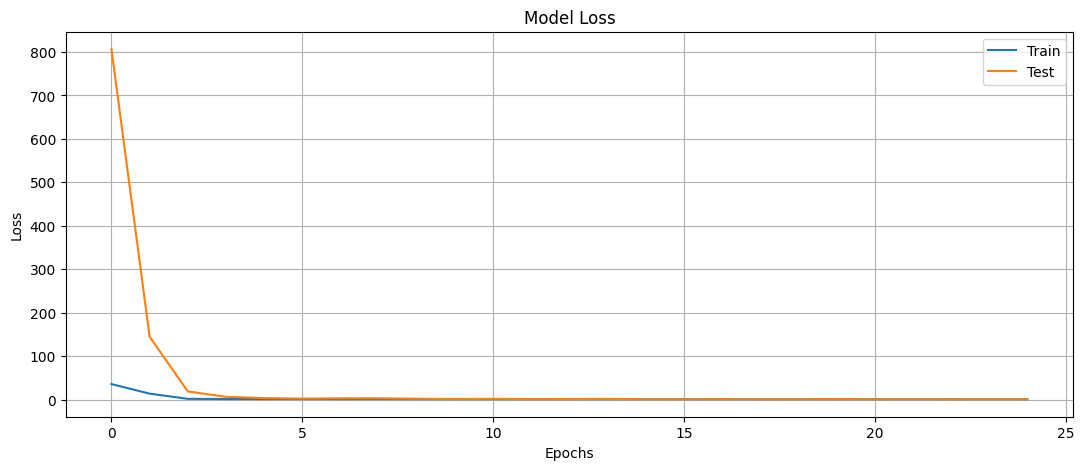

In [85]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

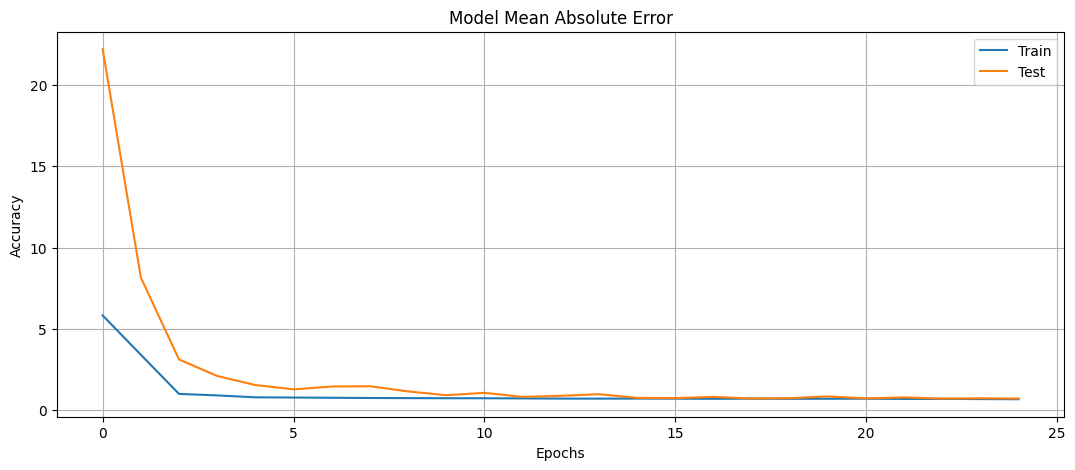

In [86]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

Measuring the performance of model

In [87]:
y_pred = model.predict(x_test).flatten()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [88]:
# Looking at the predictions
for i in range(len(y_pred)):
    print("actual: ", y_test[i], "predicted: ", y_pred[i])

actual:  5.2839966563652006 predicted:  5.8628025
actual:  8.494850021680094 predicted:  6.169815
actual:  9.167491087293763 predicted:  7.943155
actual:  6.508638306165728 predicted:  6.1135607
actual:  7.537602002101044 predicted:  6.441187
actual:  6.327902142064283 predicted:  6.0948887
actual:  5.698970004336019 predicted:  6.280389
actual:  7.823908740944319 predicted:  7.3389964
actual:  8.443697499232712 predicted:  5.761383
actual:  5.619788758288394 predicted:  6.42298
actual:  6.853871964321762 predicted:  6.547324
actual:  5.568636235841013 predicted:  5.9099913
actual:  6.337242168318426 predicted:  7.232445
actual:  5.221848749616356 predicted:  5.8154974
actual:  5.958607314841775 predicted:  6.1625624
actual:  6.769551078621726 predicted:  6.0902524
actual:  7.537602002101044 predicted:  6.345703
actual:  7.721246399047171 predicted:  6.709446
actual:  6.050609993355088 predicted:  5.904722
actual:  7.744727494896694 predicted:  5.9549694
actual:  5.251811972993799 pred

In [89]:

# Calculate the C-Index
ci = concordance_index(y_test, y_pred)
print("concordance index: " , ci)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("mean_squared_error: ", mse)

# Calculate pearson correlation
pearson_corr, p_value = pearsonr(y_test, y_pred)
print("pearson correlation: ", pearson_corr)

concordance index:  0.6265677378736753
mean_squared_error:  0.8631105198066067
pearson correlation:  0.4336023987687343
